# 0. Mount drive & import packages

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/LDS0_K273_DamThiMinhPhuong/Project/Project3_SentimentAnalysis'

/content/gdrive/My Drive/LDS0_K273_DamThiMinhPhuong/Project/Project3_SentimentAnalysis


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

# 1. Load data

In [56]:
data = pd.read_csv('data/foodyDataFinal_clean2.csv', index_col=0)

In [5]:
data.head()

,name,review_text,review_score,review_score_bins,label,review_text_clean
0,Chícc Chícc - Gà Rán Hàn Quốc,"Gà tắm mắm, phô mai kéo sợi siêu ngon, giá mềm",10.0,"(9, 10]",1,gà mắm phô kéo sợi siêu ngon giá mềm .
1,Chícc Chícc - Gà Rán Hàn Quốc,"Gà BBQ Hàn, phô mai kéo sợi siêu ngon, giá mềm",10.0,"(9, 10]",1,gà hàn phô kéo sợi siêu ngon giá mềm .
11,Chícc Chícc - Gà Rán Hàn Quốc,Gà với khoai tây quá mặn,1.0,"(0, 1]",0,gà tây mặn .
16,Chícc Chícc - Gà Rán Hàn Quốc,Mình vừa đặt 1 phần gà 92k và vô cùng thất vọn...,4.2,"(4, 5]",0,gà vô_cùng thất_vọng gà bở mặn lớp bột chiên x...
17,Chícc Chícc - Gà Rán Hàn Quốc,"Đồ ăn chuẩn vị hàn quốc, ngon giá cả hợp lí",9.2,"(9, 10]",1,đồ chuẩn vị hàn quốc ngon giá_cả hợp_lí .


In [6]:
data.shape

(33632, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33632 entries, 0 to 77657
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               33632 non-null  object 
 1   review_text        33632 non-null  object 
 2   review_score       33632 non-null  float64
 3   review_score_bins  33632 non-null  object 
 4   label              33632 non-null  int64  
 5   review_text_clean  33632 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB


In [8]:
df = data[['review_text_clean','label']]
df.head()

,review_text_clean,label
0,gà mắm phô kéo sợi siêu ngon giá mềm .,1
1,gà hàn phô kéo sợi siêu ngon giá mềm .,1
11,gà tây mặn .,0
16,gà vô_cùng thất_vọng gà bở mặn lớp bột chiên x...,0
17,đồ chuẩn vị hàn quốc ngon giá_cả hợp_lí .,1


In [9]:
df['WORDS'] = df['review_text_clean'].map(lambda x: len(x.split()))
df.head()

,review_text_clean,label,WORDS
0,gà mắm phô kéo sợi siêu ngon giá mềm .,1,10
1,gà hàn phô kéo sợi siêu ngon giá mềm .,1,10
11,gà tây mặn .,0,4
16,gà vô_cùng thất_vọng gà bở mặn lớp bột chiên x...,0,13
17,đồ chuẩn vị hàn quốc ngon giá_cả hợp_lí .,1,9


In [10]:
df['WORDS'].describe()

count    33632.000000
mean        30.705667
std         23.879112
min          1.000000
25%         14.000000
50%         26.000000
75%         41.000000
max        824.000000
Name: WORDS, dtype: float64

In [11]:
len(df['WORDS'][df['WORDS']==0])

0

1    24671
0     8961
Name: label, dtype: int64


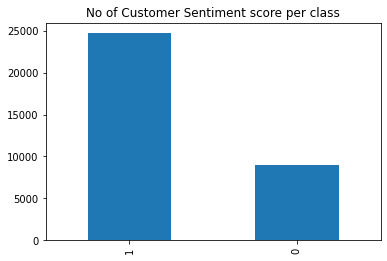

In [15]:
count = df['label'].value_counts()
print(count)
count.plot(kind='bar')
plt.title('No of Customer Sentiment score per class')
plt.show()

In [16]:
# Split input & output
X = df.review_text_clean
Y = df.label

In [17]:
# # Oversampling
# from imblearn.over_sampling import SMOTE
# sm = SMOTE()
# X_sm, Y_sm = sm.fit_resample(X,Y)

In [18]:
X.shape, Y.shape

((33632,), (33632,))

In [19]:
X.head()

0                gà mắm phô kéo sợi siêu ngon giá mềm .
1                gà hàn phô kéo sợi siêu ngon giá mềm .
11                                         gà tây mặn .
16    gà vô_cùng thất_vọng gà bở mặn lớp bột chiên x...
17            đồ chuẩn vị hàn quốc ngon giá_cả hợp_lí .
Name: review_text_clean, dtype: object

In [20]:
Y.head()

0     1
1     1
11    0
16    0
17    1
Name: label, dtype: int64

In [21]:
Y = to_categorical(Y, 2, dtype ="uint8")
Y = pd.DataFrame(Y)

In [22]:
Y.head()

,0,1
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# 2. Process the data

In [24]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',
                lower=True, 
                split=' ')
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train) 
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len) 
# text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [25]:
print(sequences[:2])

[[470, 42, 17, 271, 219, 158, 420, 4, 67, 448, 621, 657, 952, 6, 88, 273, 1, 2, 25, 113, 420, 106, 1, 2, 947, 1, 2, 5, 25, 336, 12, 21, 771, 3, 24, 109, 649, 46, 185, 1, 2, 117, 371, 303, 89], [95, 1, 75, 7, 50, 3, 11, 40, 5, 1, 2, 135, 372]]


In [ ]:
# sequence_matrix[:2]

# 3. Build RNN Network

### 3.1 Model 1

In [26]:
model = Sequential()
model.add(Embedding(max_words,50))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 96,594
Trainable params: 96,594
Non-trainable params: 0
_________________________________________________________________


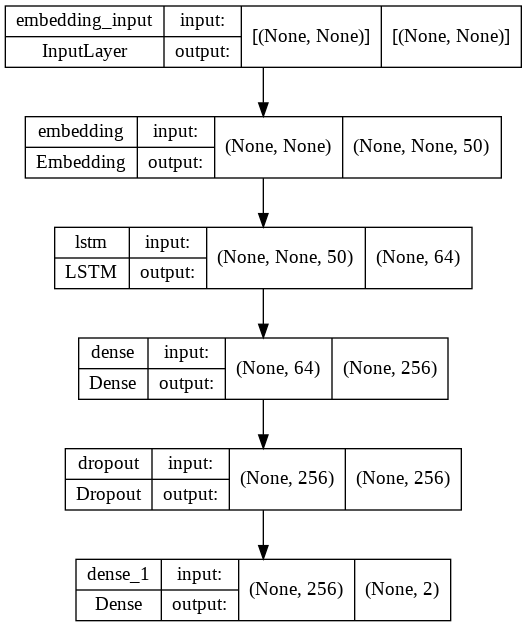

In [28]:
plot_model(model, to_file='customer_sentiment_model.png', show_shapes=True)
# Image(filename='customer_sentiment_model.png')

In [29]:
history = model.fit(sequence_matrix, y_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
148/148 [==============================] - 10s 16ms/step - loss: 0.3781 - accuracy: 0.8402 - val_loss: 0.3765 - val_accuracy: 0.8522
Epoch 2/50
148/148 [==============================] - 2s 12ms/step - loss: 0.2924 - accuracy: 0.8875 - val_loss: 0.3433 - val_accuracy: 0.8679
Epoch 3/50
148/148 [==============================] - 2s 13ms/step - loss: 0.2800 - accuracy: 0.8953 - val_loss: 0.3762 - val_accuracy: 0.8598
Epoch 4/50
148/148 [==============================] - 2s 13ms/step - loss: 0.2693 - accuracy: 0.9001 - val_loss: 0.2974 - val_accuracy: 0.8836
Epoch 5/50
148/148 [==============================] - 2s 13ms/step - loss: 0.2598 - accuracy: 0.9018 - val_loss: 0.3072 - val_accuracy: 0.8781
Epoch 6/50
148/148 [==============================] - 2s 12ms/step - loss: 0.2516 - accuracy: 0.9071 - val_loss: 0.3125 - val_accuracy: 0.8832
Epoch 7/50
148/148 [==============================] - 2s 12ms/step - loss: 0.2451 - accuracy: 0.9078 - val_loss: 0.3038 - val_accuracy: 0.883

In [30]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
4,0.259759,0.901768,0.307153,0.878106
5,0.251602,0.907131,0.312514,0.883202
6,0.245122,0.907821,0.303828,0.883839
7,0.235593,0.911644,0.331655,0.881291
8,0.230303,0.915096,0.328894,0.883415


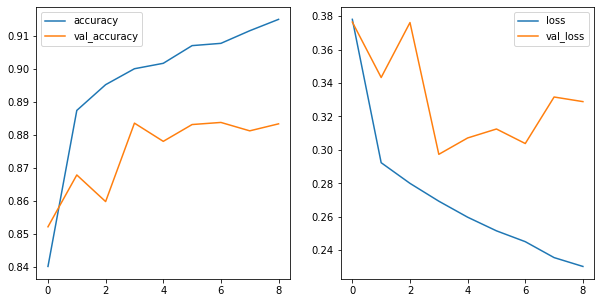

In [31]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.accuracy, label='accuracy')
plt.plot(history_df.val_accuracy, label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_df.loss, label='loss')
plt.plot(history_df.val_loss, label='val_loss')
plt.legend()
plt.show()

In [32]:
# test
test_sequence = tok.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen=max_len)

In [33]:
accr = model.evaluate(test_sequence_matrix, y_test)
print('Test set\n -Loss: {:0.3f}\n -Accuracy: {:0.3f}'.format(accr[0], accr[1]))

316/316 [==============================] - 2s 5ms/step - loss: 0.3519 - accuracy: 0.8761
Test set
 -Loss: 0.352
 -Accuracy: 0.876


In [118]:
# predict probabilities for test set
yhat_probs = model.predict(test_sequence_matrix, verbose=0)
yhat_probs[:3]

array([[0.0627458 , 0.95354325],
       [0.03275208, 0.97570205],
       [0.05498072, 0.96004313]], dtype=float32)

In [119]:
y_pred_bool = np.argmax(yhat_probs, axis=1)
y_pred_bool

array([1, 1, 1, ..., 0, 1, 0])

In [120]:
from sklearn.metrics import classification_report,confusion_matrix
print('--- Confusion matrix\n', confusion_matrix(y_test[1], y_pred_bool))
print('--- Classification report\n',classification_report(y_test[1],y_pred_bool))

--- Confusion matrix
 [[2018  713]
 [ 554 6805]]
--- Classification report
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      2731
           1       0.91      0.92      0.91      7359

    accuracy                           0.87     10090
   macro avg       0.84      0.83      0.84     10090
weighted avg       0.87      0.87      0.87     10090



In [138]:
# Save the result
model.save('customer_sentiment1.h5')

### 3.2 Model2

In [35]:
max_words = 5000
max_len = 120
tok = Tokenizer(num_words=max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',
                lower=True, 
                split=' ')
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train) 
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len) 

In [36]:
model2 = Sequential()
model2.add(Embedding(max_words,50))
model2.add(LSTM(64))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='sigmoid'))

model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [37]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          250000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 296,594
Trainable params: 296,594
Non-trainable params: 0
_________________________________________________________________


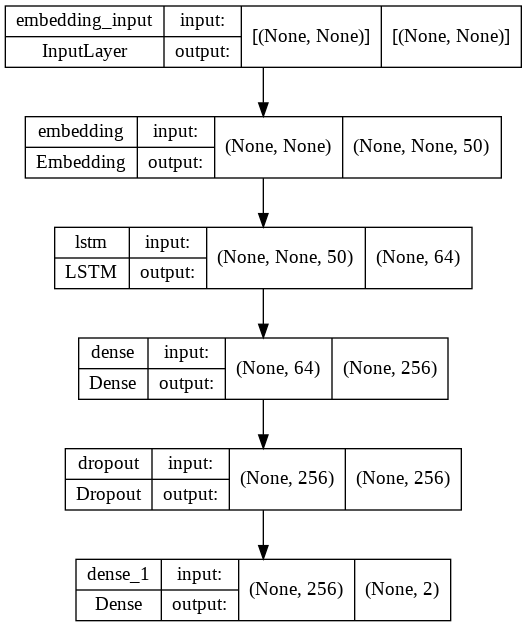

In [38]:
plot_model(model, to_file='customer_sentiment_model2.png', show_shapes=True)
# Image(filename='customer_sentiment_model2.png')

In [39]:
history2 = model2.fit(sequence_matrix, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_split=0.3,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
258/258 [==============================] - 6s 13ms/step - loss: 0.3607 - accuracy: 0.8522 - val_loss: 0.3843 - val_accuracy: 0.8590
Epoch 2/50
258/258 [==============================] - 3s 11ms/step - loss: 0.2808 - accuracy: 0.8971 - val_loss: 0.3063 - val_accuracy: 0.8842
Epoch 3/50
258/258 [==============================] - 3s 11ms/step - loss: 0.2655 - accuracy: 0.9029 - val_loss: 0.3156 - val_accuracy: 0.8785
Epoch 4/50
258/258 [==============================] - 3s 11ms/step - loss: 0.2519 - accuracy: 0.9066 - val_loss: 0.3283 - val_accuracy: 0.8792
Epoch 5/50
258/258 [==============================] - 3s 11ms/step - loss: 0.2427 - accuracy: 0.9102 - val_loss: 0.3181 - val_accuracy: 0.8815
Epoch 6/50
258/258 [==============================] - 3s 11ms/step - loss: 0.2341 - accuracy: 0.9135 - val_loss: 0.3088 - val_accuracy: 0.8764
Epoch 7/50
258/258 [==============================] - 3s 11ms/step - loss: 0.2244 - accuracy: 0.9181 - val_loss: 0.3088 - val_accuracy: 0.8798

In [40]:
history2_df = pd.DataFrame(history2.history)
history2_df.tail()

,loss,accuracy,val_loss,val_accuracy
2,0.265501,0.902907,0.315648,0.878522
3,0.251943,0.906608,0.328254,0.879230
4,0.242714,0.910189,0.318079,0.881495
5,0.234105,0.913466,0.308761,0.876398
6,0.224372,0.918138,0.308832,0.879796


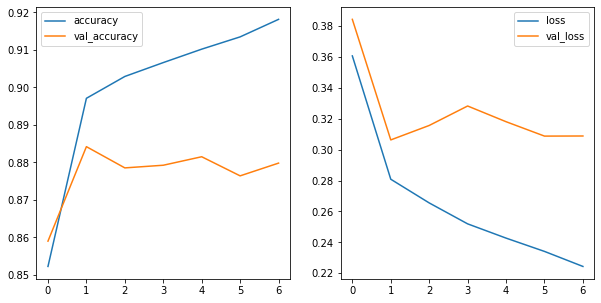

In [41]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2_df.accuracy, label='accuracy')
plt.plot(history2_df.val_accuracy, label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history2_df.loss, label='loss')
plt.plot(history2_df.val_loss, label='val_loss')
plt.legend()
plt.show()

In [42]:
# test
test_sequence = tok.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen=max_len)
accr = model2.evaluate(test_sequence_matrix, y_test)
print('Test set\n -Loss: {:0.3f}\n -Accuracy: {:0.3f}'.format(accr[0], accr[1]))

316/316 [==============================] - 1s 5ms/step - loss: 0.3160 - accuracy: 0.8802
Test set
 -Loss: 0.316
 -Accuracy: 0.880


In [135]:
# predict probabilities for test set
yhat_probs2 = model2.predict(test_sequence_matrix, verbose=0)
yhat_probs2[:3]

array([[0.05472205, 0.91428494],
       [0.01034759, 0.9785729 ],
       [0.12778851, 0.83889735]], dtype=float32)

In [136]:
y_pred_bool2 = np.argmax(yhat_probs2, axis=1)
y_pred_bool2

array([1, 1, 1, ..., 0, 1, 0])

In [137]:
from sklearn.metrics import classification_report,confusion_matrix
print('--- Confusion matrix\n', confusion_matrix(y_test[1], y_pred_bool2))
print('--- Classification report\n',classification_report(y_test[1],y_pred_bool2))

--- Confusion matrix
 [[1911  820]
 [ 486 6873]]
--- Classification report
               precision    recall  f1-score   support

           0       0.80      0.70      0.75      2731
           1       0.89      0.93      0.91      7359

    accuracy                           0.87     10090
   macro avg       0.85      0.82      0.83     10090
weighted avg       0.87      0.87      0.87     10090



In [88]:
# Save the result
# model2.save('customer_sentiment2.h5')

### 3.3 Model 3

In [44]:
max_words = 10000
max_len = 300
tok = Tokenizer(num_words=max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',
                lower=True, 
                split=' ')
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train) 
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len) 

In [45]:
model3 = Sequential()
model3.add(Embedding(max_words,50))
model3.add(LSTM(256))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='sigmoid'))

model3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [46]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          500000    
                                                                 
 lstm_2 (LSTM)               (None, 256)               314368    
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)              

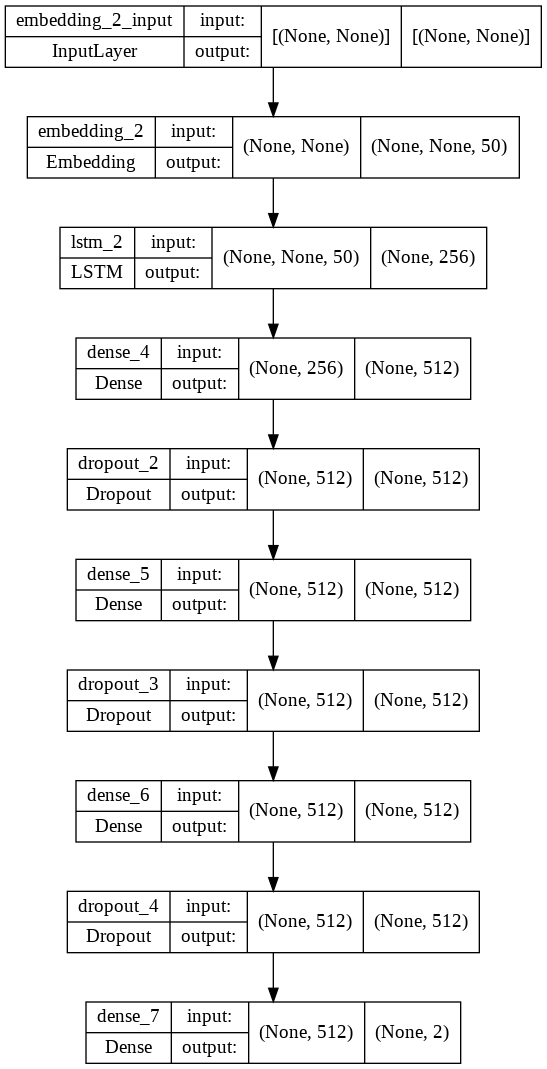

In [47]:
plot_model(model3, to_file='customer_sentiment_model3.png', show_shapes=True)
# Image(filename='customer_sentiment_model3.png')

In [48]:
history3 = model3.fit(sequence_matrix, y_train,
                    batch_size=64,
                    epochs=60,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/60
295/295 [==============================] - 14s 37ms/step - loss: 0.4004 - accuracy: 0.8433 - val_loss: 0.3518 - val_accuracy: 0.8596
Epoch 2/60
295/295 [==============================] - 10s 35ms/step - loss: 0.3118 - accuracy: 0.8870 - val_loss: 0.2985 - val_accuracy: 0.8874
Epoch 3/60
295/295 [==============================] - 10s 35ms/step - loss: 0.2825 - accuracy: 0.8994 - val_loss: 0.3274 - val_accuracy: 0.8751
Epoch 4/60
295/295 [==============================] - 10s 35ms/step - loss: 0.2668 - accuracy: 0.9039 - val_loss: 0.4639 - val_accuracy: 0.8299
Epoch 5/60
295/295 [==============================] - 10s 35ms/step - loss: 0.2483 - accuracy: 0.9107 - val_loss: 0.3411 - val_accuracy: 0.8643
Epoch 6/60
295/295 [==============================] - 10s 35ms/step - loss: 0.2367 - accuracy: 0.9165 - val_loss: 0.3809 - val_accuracy: 0.8645
Epoch 7/60
295/295 [==============================] - 10s 35ms/step - loss: 0.2167 - accuracy: 0.9229 - val_loss: 0.3383 - val_accuracy:

In [49]:
history3_df = pd.DataFrame(history3.history)
history3_df.tail()

,loss,accuracy,val_loss,val_accuracy
2,0.282543,0.899379,0.327440,0.875133
3,0.266773,0.903892,0.463924,0.829900
4,0.248317,0.910742,0.341095,0.864302
5,0.236737,0.916476,0.380944,0.864515
6,0.216723,0.922901,0.338309,0.882141


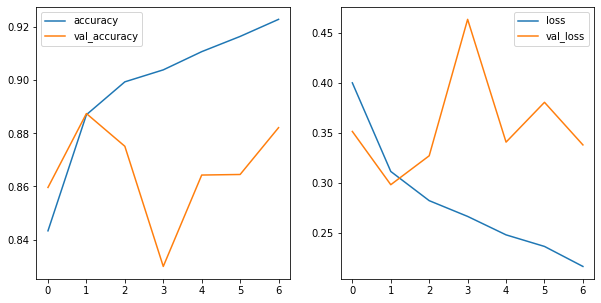

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3_df.accuracy, label='accuracy')
plt.plot(history3_df.val_accuracy, label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history3_df.loss, label='loss')
plt.plot(history3_df.val_loss, label='val_loss')
plt.legend()
plt.show()

In [51]:
# test
test_sequence = tok.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen=max_len)

In [52]:
accr = model3.evaluate(test_sequence_matrix, y_test)
print('Test set\n -Loss: {:0.3f}\n -Accuracy: {:0.3f}'.format(accr[0], accr[1]))

316/316 [==============================] - 3s 10ms/step - loss: 0.3737 - accuracy: 0.8758
Test set
 -Loss: 0.374
 -Accuracy: 0.876


In [132]:
# predict probabilities for test set
yhat_probs3 = model3.predict(test_sequence_matrix, verbose=0)
yhat_probs3[:3]

array([[0.19888698, 0.8281008 ],
       [0.20232765, 0.8205261 ],
       [0.40262848, 0.6144732 ]], dtype=float32)

In [133]:
y_pred_bool3 = np.argmax(yhat_probs3, axis=1)
y_pred_bool3

array([1, 1, 1, ..., 1, 1, 1])

In [134]:
from sklearn.metrics import classification_report,confusion_matrix
print('--- Confusion matrix\n', confusion_matrix(y_test[1], y_pred_bool3))
print('--- Classification report\n',classification_report(y_test[1],y_pred_bool3))

--- Confusion matrix
 [[ 127 2604]
 [ 468 6891]]
--- Classification report
               precision    recall  f1-score   support

           0       0.21      0.05      0.08      2731
           1       0.73      0.94      0.82      7359

    accuracy                           0.70     10090
   macro avg       0.47      0.49      0.45     10090
weighted avg       0.59      0.70      0.62     10090



# Nhận xét:
Dựa trên accuracy, confusion matrix và classification report
trong 3 model xây dựng dựa trên RNN, Model 1 cho kết quả tốt nhất.
Tuy nhiên vẫn chưa tốt bằng SGDClassifier đã chọn ở file trước.